# Szacowanie potrzeb wypożyczalni sprzętu narciarskiego

#### Na motywach przykładu:
https://microsoft.github.io/sql-ml-tutorials/python/rentalprediction/

### Standardowe pakiety wykorzystywane w języku Python zawierające algorytmy uczenia maszynowego

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

### Zastosujemy narzędzia z pakietu *revoscalepy*

In [2]:
from revoscalepy import RxComputeContext, \
                        RxInSqlServer, \
                        RxSqlServerData
from revoscalepy import rx_import


Express Edition will continue to be enforced.


In [3]:
conn_str = 'Driver=SQL Server;Server=.;Database=TutorialDB;Trusted_Connection=True;'

### Opis kolumn, które będą importowane do analiz

In [4]:
column_info = {
         "Year" : { "type" : "integer" },
         "Month" : { "type" : "integer" },
         "Day" : { "type" : "integer" },
         "RentalCount" : {  "type" : "integer" },
         "WeekDay" : {
             "type" : "factor",
             "levels" : ["1", "2", "3", "4", "5", "6", "7"]
         },
         "Holiday" : {
             "type" : "factor",
             "levels" : ["1", "0"]
         },
         "Snow" : {
             "type" : "factor",
             "levels" : ["1", "0"]
         }
     }

### Pobierz dane z tabeli z serwera SQL

In [5]:
data_source = RxSqlServerData(table="dbo.rental_data",
                               connection_string=conn_str, column_info=column_info)

#### Określ parametry z jakimi zostanie utworzony kontekst działania analiz i stwórz obiekt kontekstu wewnątrz serwera SQL

In [6]:
compute_context = RxInSqlServer(
     connection_string = conn_str,
     num_tasks = 1,
     auto_cleanup = False
)

#### Weryfikacja typu instancji obiektu compute_context

In [7]:
type(compute_context)

revoscalepy.computecontext.RxInSqlServer.RxInSqlServer

#### Zaimportuj dane do obiektu DataFrame z pakietu Pandas

In [8]:
df = pd.DataFrame(rx_import(input_data = data_source))
#print("Obiekt Data Frame:", df.stack())

Rows Read: 453, Total Rows Processed: 453, Total Chunk Time: 0.013 seconds 


In [9]:
df.head(n=3)

,Year,Month,Day,RentalCount,WeekDay,Holiday,Snow,FHoliday,FSnow,FWeekDay
0,2014,1,20,445,2,1,0,1,0,2
1,2014,2,13,40,5,0,0,0,0,5
2,2013,3,10,456,1,0,0,0,0,1


### Małe zmiany w obiekcie DataFrame - nowa kolumna *Date* i usuwamy kolumny *Year, Month oraz Day*

In [10]:
df['Date'] = pd.Series(pd.to_datetime(df['Day'].astype(str) + "/" +
                                      df['Month'].astype(str) + "/" +
                                      df['Year'].astype(str), format = "%d/%m/%Y"))

In [11]:
#columns_to_drop = ['Year', 'Month', 'Day']
#df.drop(columns_to_drop, axis=1, inplace=True)

In [12]:
df.head(n=5)

,Year,Month,Day,RentalCount,WeekDay,Holiday,Snow,FHoliday,FSnow,FWeekDay,Date
0,2014,1,20,445,2,1,0,1,0,2,2014-01-20
1,2014,2,13,40,5,0,0,0,0,5,2014-02-13
2,2013,3,10,456,1,0,0,0,0,1,2013-03-10
3,2014,3,31,38,2,0,0,0,0,2,2014-03-31
4,2014,4,24,23,5,0,0,0,0,5,2014-04-24


#### Pobierz wszystkie kolumny z obiektu *df*

In [13]:
columns = df.columns.tolist()
print(columns)

['Year', 'Month', 'Day', 'RentalCount', 'WeekDay', 'Holiday', 'Snow', 'FHoliday', 'FSnow', 'FWeekDay', 'Date']


#### Filtruj kolumny i usuń te, których nie chcesz używać do dalszej analizy

In [14]:
columnsF = [c for c in columns if c not in ["Date", "Year", 'Month', 'Day', 'FHoliday', 'FSnow', 'FWeekDay']]

In [15]:
columnsF

['RentalCount', 'WeekDay', 'Holiday', 'Snow']

### Tworzenie modelu

$Y=b_1X_1+b_2X_2+...+b_nX_n+a$ <br>
$gdzie:$ <br>
$Y$  **to zmienna objaśniana, zmienna zależna**<br>
$b_1,b_2,b_n$  **współczynniki regresji wyliczone dla poszczególnych predyktorów w modelu** <br>
$X_1,X_2,X_n$  **wartości predyktorów** *(w naszym przypadku Month, Day, WeekDay, Holiday, Snow)* <br> 
$a$ **wyraz wolny**

#### Progonozy wartości dla zmiennej *RentalCount*  są celem tworzonego modelu. *RentalCount* jest w naszym przypadku zmienną objaśnianą *Y*

In [16]:
target = 'RentalCount'

#### Opis zmiennej *RentalCount*

In [18]:
df[target].describe()

count    453.000000
mean     158.437086
std      195.155154
min       20.000000
25%       34.000000
50%       44.000000
75%      280.000000
max      846.000000
Name: RentalCount, dtype: float64

#### Opis w postaci graficznej

In [19]:
%matplotlib inline
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.dates import YEARLY, DateFormatter, rrulewrapper, RRuleLocator, drange
import seaborn

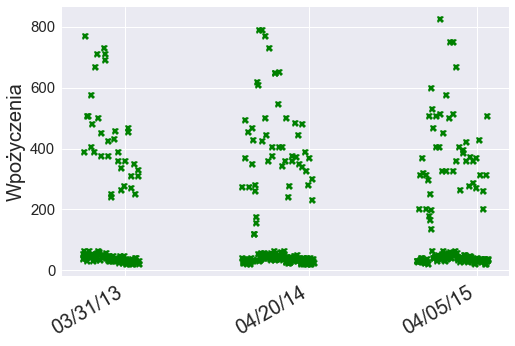

In [81]:
rule = rrulewrapper(YEARLY, byeaster=0, interval=1)
loc = RRuleLocator(rule)
formatter = DateFormatter('%m/%d/%y')
period = (df['Date'] > '01/01/2013') & (df['Date'] <= '30/06/2015')
fig, ax = plt.subplots()
plt.plot_date(df.Date.loc[period], df.RentalCount.loc[period], fmt="go", tz=None, xdate=True, marker='X')
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_label_text(label = 'Wpożyczenia',fontsize=20)
ax.yaxis.set_tick_params(labelsize=15)
labels = ax.get_xticklabels()
plt.setp(labels, rotation=30, fontsize=20)
plt.figure(figsize=(20, 10), dpi=200)
fig.autofmt_xdate()
plt.show()

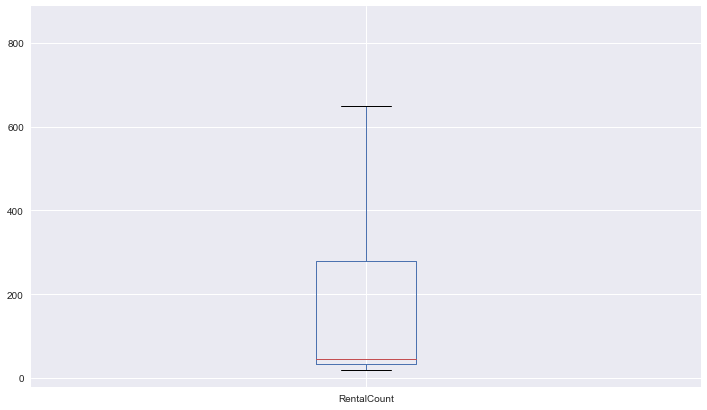

In [22]:
df[target].plot(kind='box', figsize=[12,7], grid=True)

#### Stwórz zbiór uczący - argument *random_state* jest ziarnem dla generatora liczb losowych

In [23]:
train = df.sample(frac=0.80, random_state=3)

#### Zbiór testowy jest rałą reszą nie będącą zbiorem uczącym

In [24]:
test = df.loc[~df.index.isin(train.index)]

#### Pokaż rozmiar obydwu zbiorów

In [25]:
print("Rozmiar zbioru uczącego:", train.shape)
print("Rozmiar zbioru testowego:", test.shape)

Rozmiar zbioru uczącego: (362, 11)
Rozmiar zbioru testowego: (91, 11)


#### Stwórz instancję obiektu klasy *LinearRegression* pochodzącej z pakietu *sklearn.linear_model*

In [26]:
lin_model = LinearRegression()

In [28]:
print(train[columnsF].shape)
print(train[target].shape)

(362, 4)
(362,)


#### Dopasuj model do danych ze zbioru uczącego

In [30]:
lin_model.fit(train[columnsF], train[target])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

#### Odczytujemy współczynniki (*ang. Coefficients*) modelu

In [31]:
print('Współczynniki równania: \n', len(lin_model.coef_))

Współczynniki równania: 
 4


In [46]:
pd.DataFrame(list(zip(train[columnsF],lin_model.coef_)), columns=['Cechy', 'Wspolczynniki'])

,Cechy,Wspolczynniki
0,RentalCount,1.000000e+00
1,WeekDay,-9.791084e-16
2,Holiday,3.666289e-15
3,Snow,-5.520664e-15


#### Generuj dane prognozowane z wykorzystaniem zbudowanego modelu na danych pochodzących ze zbioru testowego

In [47]:
lin_predictions = lin_model.predict(test[columnsF])
print("Dane prognozowane:", lin_predictions)

Dane prognozowane: [ 445.   40.  456.  240.   37.  297.   36.   33.   25.   38.   30.   48.
  405.   31.  280.  468.   44.   20.  709.  260.   21.  370.   41.  790.
   37.   63.  120.   43.   24.  390.  468.   37.  351.  370.   44.   40.
   22.   46.   37.   21.   29.   39.   23.  648.   26.   28.   35.   29.
  390.   40.   24.   46.   39.   50.   43.   48.   63.   44.   50.   32.
  327.  350.  651.  327.   33.  444.   37.  468.   41.   48.   39.   35.
  374.   39.   25.   39.  729.   44.   25.   28.   30.   39.  479.  429.
  507.   33.   40.   29.  200.   57.   50.]


In [ ]:
print(type(test[target]))
print(test[target])
print(len(test[target]), len(lin_predictions))

#### Weryfikacja graficzna otrzymanych wyników

In [49]:
import numpy as np

In [55]:
org_pred = pd.DataFrame({'pred': np.int_(lin_predictions.tolist())})
org_pred['orig'] = pd.Series(test[target].reset_index(drop=True))
org_pred.head(n=10)

,pred,orig
0,444,445
1,40,40
2,455,456
3,239,240
4,37,37
5,296,297
6,36,36
7,33,33
8,25,25
9,38,38


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000018001D2E198>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x0000018001D7D5F8>], dtype=object)

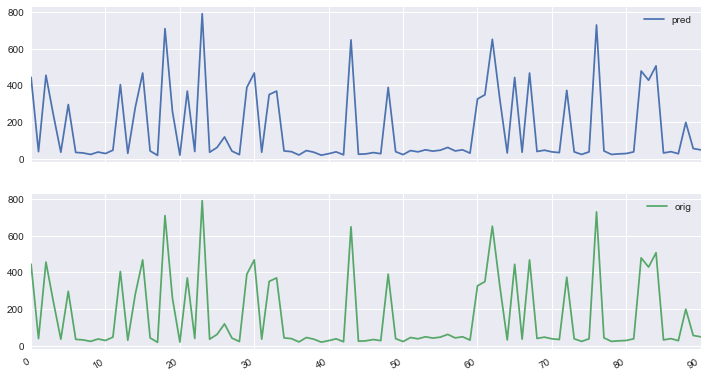

In [56]:
org_pred.plot(kind='line', figsize=[12,7], grid=True, subplots=True)

#### Zweryfikuj w jakim stopniu model poprawnie prognozuje dane. Jako parametr określający poprawność działania modelu, użyjemy *średni błąd kwadratowy*. 

<img src="./mse_graph1.png" height="400" width="400">

In [52]:
lin_mse = mean_squared_error(y_pred=lin_predictions, y_true=test[target])
# ;-D
print("MSE: %.40f" %lin_mse)

MSE: 0.0000000000000000000000000075745903991252


In [53]:
ms_e = np.mean((test[target]-lin_predictions)**2)
ms_e

7.574590399125217e-27

In [54]:
r2sc = r2_score(y_pred=lin_predictions, y_true=test[target])
r2sc

1.0

### Dalszy ciąg w Microsoft SQL Server Management Studio

In [42]:
lin_model.get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': 1, 'normalize': False}

In [43]:
df.sort_values(by=['Date'], ascending=[1]).head(n=10)

,Year,Month,Day,RentalCount,WeekDay,Holiday,Snow,FHoliday,FSnow,FWeekDay,Date
395,2013,1,1,846,3,1,1,1,1,3,2013-01-01
227,2013,1,2,36,4,0,0,0,0,4,2013-01-02
273,2013,1,3,54,5,0,0,0,0,5,2013-01-03
447,2013,1,4,63,6,0,1,0,1,6,2013-01-04
156,2013,1,5,390,7,0,0,0,0,7,2013-01-05
327,2013,1,6,769,1,0,1,0,1,1,2013-01-06
47,2013,1,7,52,2,0,0,0,0,2,2013-01-07
220,2013,1,8,42,3,0,0,0,0,3,2013-01-08
261,2013,1,9,39,4,0,0,0,0,4,2013-01-09
82,2013,1,10,40,5,0,0,0,0,5,2013-01-10


In [44]:
df.keys()

Index(['Year', 'Month', 'Day', 'RentalCount', 'WeekDay', 'Holiday', 'Snow',
       'FHoliday', 'FSnow', 'FWeekDay', 'Date'],
      dtype='object')

In [45]:
lin_model.intercept_

5.6843418860808015e-14

#### todo: use prophet package